# Appendix 1

**Simulation Code**

In [7]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
#First things first lets get all our important pickle files
with open('RegulationInfectivity.pickle', 'rb') as handle:
    regInfect = pickle.load(handle)
with open('landBorders.pickle', 'rb') as handle:
    borders = pickle.load(handle)
with open('touristNumbers.pickle', 'rb') as handle:
    touristNum = pickle.load(handle)
with open('Threshold.pickle', 'rb') as handle:
    threshold = pickle.load(handle)
with open('countryRegions.pickle', 'rb') as handle:
    regions = pickle.load(handle)
with open('countryPopulations.pickle', 'rb') as handle:
    populations = pickle.load(handle)
with open('regionToCountry.pickle', 'rb') as handle:
    regionToCountry = pickle.load(handle)

In [5]:
def runSimulation(infectMult = 1, deathRate = .1, regionMult = 3, stopday = 500, tourismMult = 100, startCountry = "Rand", borderMult = 3):
    #print("DeathRate is:", deathRate)
    countries = list(regInfect.keys())
    worldNetwork = nx.Graph()
    
    #we need to add all countries to our network, lets also add them all to our infectivity tracker
    #worldNetwork.add_nodes_from(countries)
    #We need a list of 10, so we can keep track of the dates everyone is infected and when they will recover
    #We also need a regulation tracker
    regulationTracker = {}
    infectTracker = {}
    for country in countries:
        infectTracker[country] = {"curr": 0, "total": 0, "deaths": 0, "recovered": 0, "Day1": 0, "Day2": 0, "Day3": 0, "Day4": 0, "Day5": 0, "Day6": 0, "Day7": 0, 
                                  "Day8": 0, "Day9": 0, "Day10": 0, "Day11": 0, "Day12": 0, "Day13": 0, "Day14": 0, "Day15": 0, "Day16": 0, "Day17": 0, "Day18": 0,
                                 "Day19": 0, "Day20": 0}
        regulationTracker[country] = {'regs':[], 'infectRate':regInfect[country]['baseline']}
    #Lets also make a random infection in one of the countries
    if startCountry not in countries:
        firstInfect = np.random.choice(countries, 1)[0]
    else:
        firstInfect = startCountry
    print("First country Infected is: ", firstInfect)
    #fill all appropriate trackers for this country
    infectTracker[firstInfect]["curr"] = 1
    infectTracker[firstInfect]["total"] = 1
    infectTracker[firstInfect]["Day1"] = 1
    #print("Infect rate is:", regulationTracker[country]['infectRate'])
    
    #Lets create some global trackers, to update the user with as time goes on
    totalDays = 1
    totalInfect = 1
    countryInfect = 1
    deaths = 0
    recovered = 0
    worldPop = sum(populations.values())
    
    #Now we run our simulation until the stop day, or until everyone is recovered from the virus, or until the virus has infected everybody
    stop = True
    while totalDays < stopday and stop:
        #print("It is day", totalDays)
        #check if it is the first infection day, or a new week to update the status messages
        if totalDays == 1 or totalDays%7 == 0:
            print("This is day", totalDays, "of the virus,",totalInfect,"people have been infected, across", countryInfect,"countries.")
            print("There have been,",deaths,"deaths, and", recovered,"recoveries.")
            #nx.draw(worldNetwork)
        #now lets do the "turn"
        for country in countries:
            #first lets update every countries internal infections
            #Lets ignore each country that has no current infections
            #print("Current infected is: ", infectTracker[country]['curr'])
            if infectTracker[country]['curr'] > 0:
                #print("Starting on country: ", country)
                #Ok now lets infect some people, through random number generation
                #We want to make sure that we aren't overloading the system by picking over 1000 random numbers so lets set up a while loop to bring the counter down
                currInfectTemp = infectTracker[country]['curr']
                infectMultTemp = 0
                while currInfectTemp > 1000:
                    currInfectTemp /= 10
                    infectMultTemp += 10
                #make sure infectMultTemp is not 0
                if infectMultTemp == 0:
                    infectMultTemp = 1
                #Now lets pick our random numbers
                randomInfects = np.random.randint(low=1, high=1000, size=int(currInfectTemp))
                #check if we have more people infected/dead/recovered then our population
                if infectTracker[country]['total'] >= populations[country]:
                    #print("Country infections are bigger than pop")
                    newInfects = 0
                else:
                    #print("randomInfects is:", randomInfects)
                    #lets get the number of new infects, its a base infect rate of 25% multiplied by our infection multiplier, then scaled back up to the size of the original infected pop
                    newInfects = len([i for i in randomInfects if i <= regulationTracker[country]['infectRate']*infectMult*1000])*infectMultTemp
                #print("newInfects are:", newInfects)
                #Now lets get new deaths, then scale up to the original size of infected pop
                newDeaths = len([i for i in randomInfects if i <= 100*deathRate])*infectMultTemp
                #We also need a tracker to keep track of the deaths we've "Dolled out"
                deathTracker = 0
                    
                #Now lets iterate over the country data and update as necessary
                newRecovered = 0
                for day in range(20,0,-1):
                    currDay = "Day"+str(day)
                    #print("current Day is: ", currDay)
                    #We only want to edit a day if it has infections
                    if infectTracker[country][currDay] != 0 and day != 1:
                        #Lets get deaths for this specific day
                        currDayDeaths = round((infectTracker[country][currDay]/infectTracker[country]["curr"])*newDeaths)
                        deathTracker += currDayDeaths
                        #Now lets subtract these deaths from the infected this day
                        infectTracker[country][currDay] -= currDayDeaths
                        #Now we check if this is day 10, if so lets update the recovered section
                        if day == 20:
                            newRecovered = infectTracker[country][currDay]
                            #Update the recovered section
                            infectTracker[country]["recovered"] += newRecovered
                        #else we want to update the next days section with our current section
                        else:
                            infectTracker[country]["Day"+str(day+1)] = infectTracker[country][currDay]
                        #Now if its the last day we need to update everything
                    elif infectTracker[country][currDay] != 0 and day == 1:
                        #Lets get deaths for this specific day, just the remainder of the deaths-deathtracker
                        currDayDeaths = newDeaths-deathTracker
                        #Now lets subtract these deaths from the infected this day
                        infectTracker[country][currDay] -= currDayDeaths
                        
                        #Now lets updated our Day2
                        infectTracker[country]["Day"+str(day+1)] = infectTracker[country][currDay]
                        #check if adding the new infects would overdo the population size
                        if infectTracker[country]['total']+newInfects > populations[country]:
                            newInfects = populations[country]-infectTracker[country]['total']
                        
                #Now lets update our current day with the newInfects
                infectTracker[country][currDay] = newInfects
                #Now lets update our current infections for this country, as well as deaths, total infections, and recovered
                infectTracker[country]['curr'] = infectTracker[country]['curr']+newInfects-newDeaths-newRecovered
                infectTracker[country]['total'] += newInfects
                infectTracker[country]['deaths'] += newDeaths
                infectTracker[country]['recovered'] += newRecovered
                #Now lets update the global info as well
                #print("New infects are: ", newInfects, "newDeaths are:", newDeaths, "New Recovered Are:", newRecovered)
                totalInfect += newInfects
                deaths += newDeaths
                recovered += newRecovered
            #Now lets move onto infections between countries
            #First lets determine if we need to calculate tourism numbers at all, 
            if country in touristNum and infectTracker[country]['curr'] > 0:
                #Now lets calculate tourism numbers, our number of tourists/our country population * currentInfected/population
                oddsOfTourist = (sum(touristNum[country].values())/populations[country])*(infectTracker[country]['curr']/populations[country])
                #check if travel_partial is in place which will have the oddsOfTourists
                if 'travel' in regulationTracker[country]['regs']:
                    oddsOfTourist /= 4
                elif 'travel_partial' in regulationTracker[country]['regs']:
                    oddsOfTourist /= 2
                #print("Odds of getting a tourist #1 are", oddsOfTourist)
                oddsOfTourist *= tourismMult
                if oddsOfTourist > 1:
                    oddsOfTourist = 1
                #print("Odds of getting a tourist #2 are", oddsOfTourist)
                #If we "hit" on a tourist leaving then we assign it to another country
                if np.random.choice([True, False], 1, p=[oddsOfTourist, 1-(oddsOfTourist)])[0]:
                    #print("Infecting another Country")
                    #we hit, so now we need to calculate which country got "infected"
                    #First lets multiply our region numbers for tourists
                    #We need to set the region for our country, also create a newtourists list
                    if country in regions:
                        currRegion = regions[country]
                    else:
                        currRegion = " "
                    newTourists = []
                    for touristCountry, tourists in touristNum[country].items():
                        #Check if our country shares a region
                        if touristCountry in regions and regions[touristCountry] == currRegion:
                            #multiply the tourists by our regionMult
                            tourists *= regionMult
                        #Now lets add our tourists to the new tourists list
                        newTourists.append(tourists)
                    #now lets create and fill our odds list
                    odds = []
                    sumTourists = sum(newTourists)
                    for newTourist in newTourists:
                        odds.append(newTourist/sumTourists)
                    #now lets see which country we spread to
                    countrySpread = ""
                    while countrySpread not in infectTracker:
                        countrySpread = np.random.choice(list(touristNum[country].keys()), 1, p=odds)[0]
                    #print("Country Spread is:", countrySpread)
                    #lets update that countries stats
                    infectTracker[countrySpread]["curr"] += 1
                    infectTracker[countrySpread]["total"] += 1
                    infectTracker[countrySpread]["Day1"] += 1
                    totalInfect += 1
                    #now lets check if this is the first time that country has been infected
                    if infectTracker[countrySpread]["total"] == 1:
                        #now lets update the number of countries infected
                        countryInfect += 1
                        #We also want to connect our network
                        worldNetwork.add_edge(country, countrySpread)
            #Now lets move onto cross-Land Border Infections, and additional regional infections
            #We only want to calculate if our country is currently infected
            if infectTracker[country]['curr'] > 0:
                #First lets get the odds that we have a border infection, we need to make sure the countries have land borders/we know their borders
                if country in borders:
                    oddsOfBorder = borderMult*(infectTracker[country]['curr']/populations[country])
                    #print("Odds of border:", oddsOfBorder)
                    if 'travel' in regulationTracker[country]['regs']:
                        oddsOfBorder /= 2
                    elif 'travel_partial' in regulationTracker[country]['regs']:
                        oddsOfBorder *= 0.75
                    if oddsOfBorder > 1:
                        oddsOfBorder = 1
                    #print("Odds of Border are:", oddsOfBorder)
                    #Now lets iterate across our borders and check to see if it passes their borders
                    for border in borders[country]:
                        #Check to see if there is a spread
                        if border in infectTracker and np.random.choice([True, False], 1, p=[oddsOfBorder, 1-(oddsOfBorder)])[0]:
                            infectTracker[border]["curr"] += 1
                            infectTracker[border]["total"] += 1
                            infectTracker[border]["Day1"] += 1
                            totalInfect += 1
                            #now lets check if this is the first time that country has been infected
                            if infectTracker[border]["total"] == 1:
                                #now lets update the number of countries infected
                                countryInfect += 1
                                #We also want to connect our network
                                worldNetwork.add_edge(country, border)
                #Now lets do regions
                if country in regions:
                    #Get our odds for the current country
                    oddsOfRegion = regionMult*(infectTracker[country]['curr']/populations[country])
                    if 'travel' in regulationTracker[country]['regs']:
                        oddsOfRegion /= 4
                    elif 'travel_partial' in regulationTracker[country]['regs']:
                        oddsOfRegion /= 2
                    if oddsOfRegion > 1:
                        oddsOfRegion = 1
                    #print("Odds of Region are:", oddsOfRegion)
                    currRegion = regions[country]
                    #Iterate across our countries in the same region
                    for neighbor in regionToCountry[currRegion]:
                        if neighbor in infectTracker and np.random.choice([True, False], 1, p=[oddsOfRegion, 1-(oddsOfRegion)])[0]:
                            infectTracker[neighbor]["curr"] += 1
                            infectTracker[neighbor]["total"] += 1
                            infectTracker[neighbor]["Day1"] += 1
                            totalInfect += 1
                            #now lets check if this is the first time that country has been infected
                            if infectTracker[neighbor]["total"] == 1:
                                #now lets update the number of countries infected
                                countryInfect += 1
                                #We also want to connect our network
                                worldNetwork.add_edge(country, neighbor)
            #Now lets update the regulations tracker, only for countries that have been infected
            if infectTracker[country]['total'] > 0:
                #create a variable to check if we added regulations
                newRegs = False
                #First we need to check the threshold of this country
                for key, value in threshold[country].items():
                    #Check to see we have not already added the regulation
                    if key not in regulationTracker[country]['regs']:
                        #Now check we don't use 0 values for the threshold, and check the overall threshold
                        if (value[0] != 0 and infectTracker[country]['deaths'] >= value[0]) or (value[1] != 0 and infectTracker[country]['curr'] >= value[1]):
                            #We hit the threshold so now lets add the regulations to the list
                            #Make sure that we don't change anything if travel or travel partial is on the list
                            if key != "travel" and key != "travel_partial":
                                newRegs = True
                            regulationTracker[country]['regs'].append(key)
                            #print("Regulations for country are: ", regulationTracker[country]['regs'])
                #Now lets update our infect rate based on the regulations
                if newRegs:
                    #Iterate through our reginfect to get the data on spread during regulations
                    for key, value in regInfect[country].items():
                        #We want to split all our regulations to see which ones are in 
                        regReformed = key.split(",")
                        allIn = True
                        for reg in regulationTracker[country]['regs']:
                            if reg not in regReformed:
                                allIn = False
                        if allIn:
                            #Now we want to set our new regInfect rate, lets cap it at 1.5%
                            if value < 0.03:
                                regulationTracker[country]['infectRate'] = 0.15
                            else:
                                regulationTracker[country]['infectRate'] = value
                            #print("New infect rate would be", regulationTracker[country]['infectRate'])
                            #We need to break so we don't go farther down the track
                            break
                        
                    
        #Lets make sure we stop if our infection rates sputter out
        if totalInfect <= deaths+recovered:
            print("Stopping Becuase all infected died or recovered")
            stop = False
        totalDays += 1
        #print("End of day, days are", totalDays, " Stop is", stop)
    return worldNetwork

First country Infected is:  Uruguay
This is day 1 of the virus, 1 people have been infected, across 1 countries.
There have been, 0 deaths, and 0 recoveries.
This is day 7 of the virus, 4 people have been infected, across 1 countries.
There have been, 0 deaths, and 0 recoveries.
This is day 14 of the virus, 19 people have been infected, across 1 countries.
There have been, 1 deaths, and 0 recoveries.
This is day 21 of the virus, 89 people have been infected, across 2 countries.
There have been, 5 deaths, and 1 recoveries.
This is day 28 of the virus, 398 people have been infected, across 2 countries.
There have been, 14 deaths, and 10 recoveries.
This is day 35 of the virus, 1868 people have been infected, across 2 countries.
There have been, 62 deaths, and 32 recoveries.
This is day 42 of the virus, 8003 people have been infected, across 4 countries.
There have been, 214 deaths, and 118 recoveries.
This is day 49 of the virus, 14738 people have been infected, across 8 countries.
There

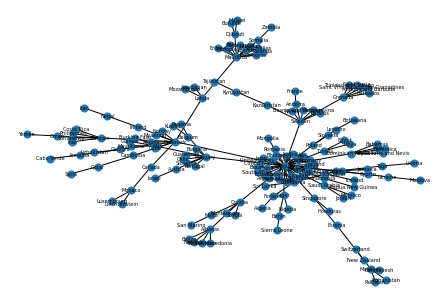

In [6]:
myGraph = runSimulation(stopday = 365, tourismMult=1000)
nx.draw(myGraph, node_size=50, with_labels=True, font_size = 5)